# Image segmentation with CamVid

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Tutorials/blob/master/FastAI/Image%20segmentation%20on%20CamVid%20dataset.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Tutorials/blob/master/FastAI/Image%20segmentation%20on%20CamVid%20dataset.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
path = untar_data(URLs.CAMVID)
URLs.CAMVID
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/valid.txt')]

In [5]:
path_lbl = path/'labels'
path_img = path/'images'
import os
import shutil

os.rename("/root/.fastai/data/camvid/images/models/*", "/content/")

FileNotFoundError: ignored

## Data

In [ ]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f01200.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08107.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06540.png')]

In [ ]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0001TP_008310_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08123_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_009030_P.png')]

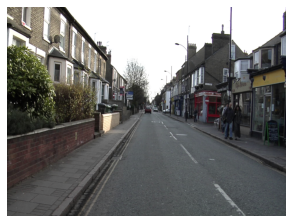

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [ ]:
get_y_fn(img_f)

PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f01200_P.png')

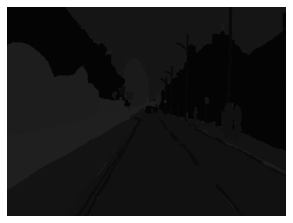

In [ ]:
img = open_image(get_y_fn(img_f))
img.show(figsize=(5,5))

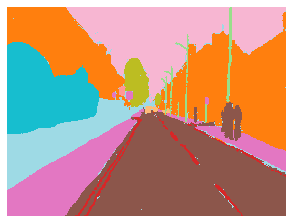

In [ ]:
#@title
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 21, 21, 30],
          [ 4,  4,  4,  ..., 21, 21, 30],
          [ 4,  4,  4,  ..., 21, 21, 30],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [ ]:
size = src_size//2
bs = 2

In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

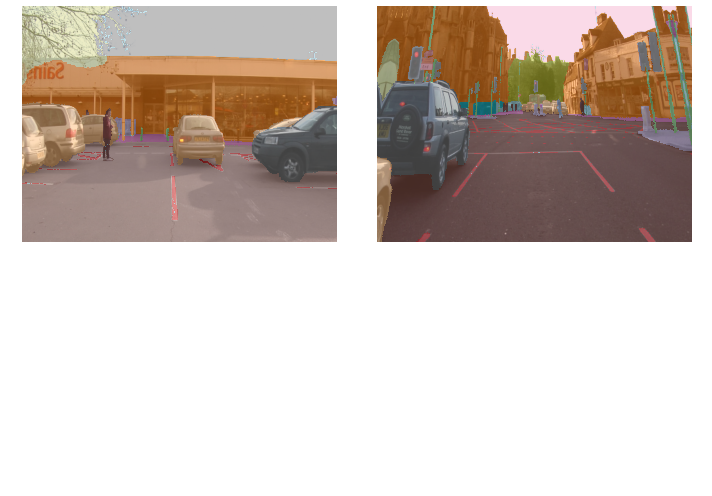

In [ ]:
data.show_batch(2, figsize=(10, 7))

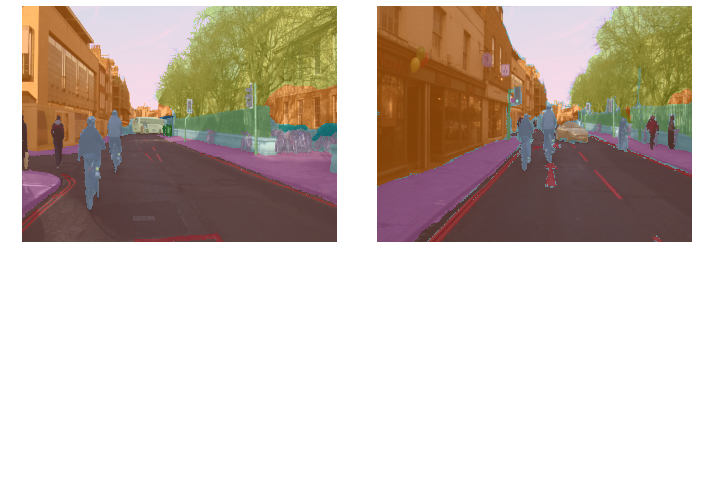

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics = acc_camvid

In [ ]:
wd = 1e-2

In [ ]:
# create unet
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


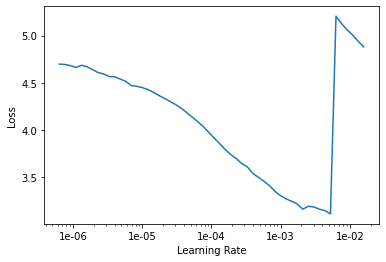

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.838195,0.717231,0.817024,01:33
1,0.698371,0.632755,0.828233,01:31
2,0.633882,0.583572,0.858766,01:30
3,0.659312,0.519077,0.859863,01:30
4,0.615740,0.463570,0.876261,01:30
5,0.607332,0.438007,0.886215,01:29
6,0.517741,0.416030,0.888927,01:29
7,0.528395,0.504612,0.867447,01:29
8,0.499495,0.391347,0.885173,01:29
9,0.403208,0.320273,0.910575,01:28


In [ ]:
print(os.getcwd())
learn.save('/content/camvid-stage-save')
learn.export('/content/camvid-stage-1')

/content


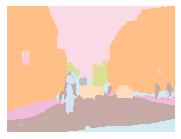

In [ ]:
test_image_url="/root/.fastai/data/camvid/images/0001TP_008310.png"
test_image=open_image(test_image_url)
#img = vision.Image(test_image)
predicted=img_predicted=learn.predict(test_image)
predicted[0].show()

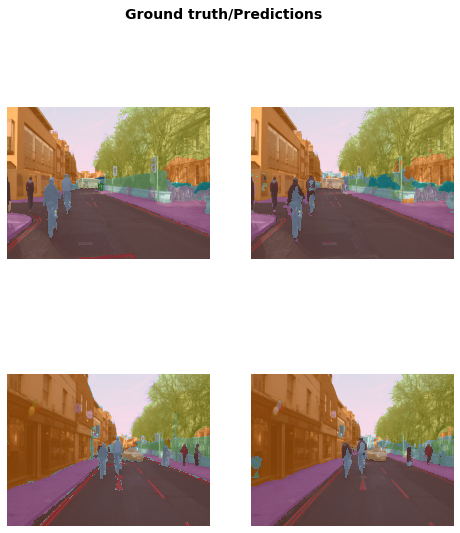

In [ ]:
learn.show_results(rows=3, figsize=(8, 9))

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


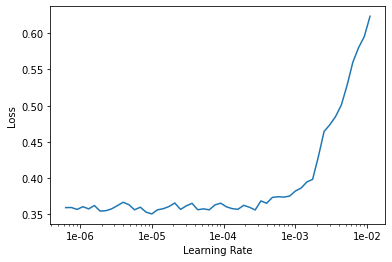

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(12, slice(lr/400, lr/4), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.366122,0.309503,0.910713,01:34
1,0.361907,0.303015,0.913407,01:34
2,0.352303,0.292203,0.917587,01:35
3,0.341147,0.287292,0.917284,01:34
4,0.337113,0.284105,0.919506,01:34
5,0.351902,0.312252,0.910956,01:35
6,0.318409,0.287685,0.917800,01:35
7,0.322084,0.308840,0.910919,01:34
8,0.322581,0.295124,0.914246,01:35
9,0.297402,0.300649,0.915356,01:35


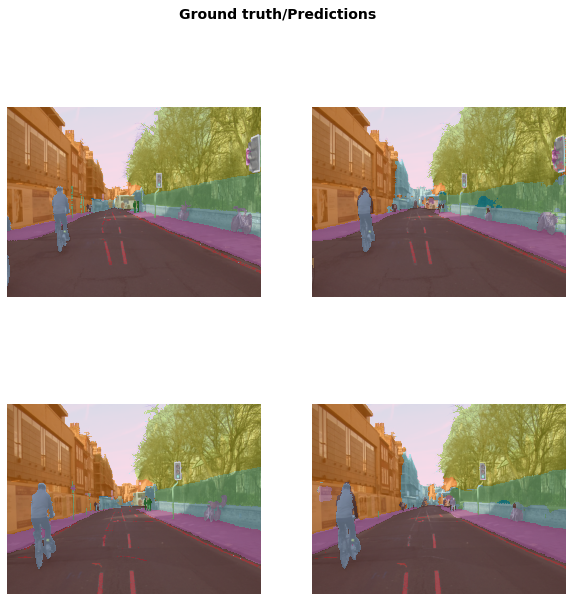

In [ ]:
learn.show_results(rows=3, figsize=(10, 10))

In [ ]:

learn.save('/content/camvid-stage-2-save')
learn.export('/content/camvid-stage-2')

## Train on bigger images

In [ ]:
size = (src_size//1.5).astype(int)
bs = 1

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('camvid-stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


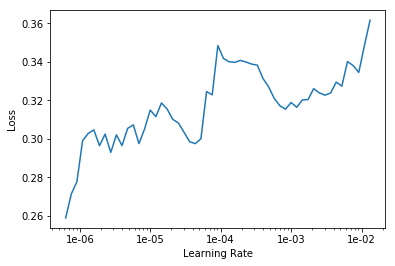

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.322703,0.311965,0.909830,06:25
1,0.301387,0.295081,0.914513,06:25
2,0.316511,0.323400,0.905250,06:25
3,0.312499,0.291573,0.917677,06:26
4,0.299996,0.326227,0.902975,06:25
5,0.301057,0.306003,0.916780,06:25
6,0.322299,0.283409,0.920348,06:26
7,0.304203,0.293696,0.918756,06:26
8,0.294726,0.330342,0.906730,06:26
9,0.231490,0.291358,0.918170,06:25


In [ ]:
learn.save('camvid-big-stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, slice(1e-6, lr/10))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.220781,0.280319,0.921519,07:29
1,0.222638,0.285122,0.919789,07:28
2,0.231188,0.282220,0.920214,07:28
3,0.210946,0.278116,0.921862,07:29
4,0.220768,0.280985,0.922390,07:29
5,0.218480,0.292877,0.919984,07:29
6,0.195990,0.296447,0.920676,07:29
7,0.199190,0.278679,0.923414,07:29
8,0.191762,0.277260,0.923442,07:29
9,0.206590,0.289219,0.921788,07:29


In [ ]:
learn.save('stage-2-big')

## Interpretation

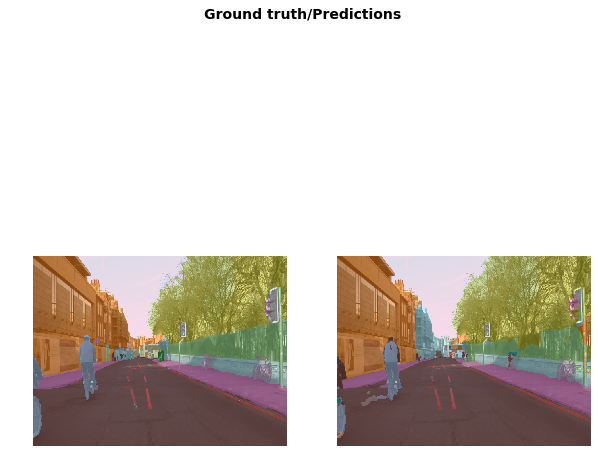

In [ ]:
learn.show_results(rows=3, figsize=(10, 10))